<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Combo_%5BGift%5D_Sidra_PAM_e_TerraClimate_para_municipios_e_culturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script "Combo" para extração de dados climáticos de um município

Autor: [A.L. Belem](https://github.com/andrebelem)<br>
UFF @ 2023<br><br>

O objetivo deste "combo" é extrair dados climáticos e de produção agrícola de uma ou mais regiões/culturas. Ele é derivado de vários exercícios e notebooks em Python desenvolvidos para a disciplina de Modelagem e Otimização de Sistemas Agrícolas e Ambientais, mas apresentado de forma mais *organizada* (e sim ! ele é quase um "presente" para quem está procurando juntar dados climáticos e de produção de uma vez só.<br>
Lembrando....<br>
(1) obter dados para a cultura ([veja aqui](http://api.sidra.ibge.gov.br/desctabapi.aspx?c=5457)) diretamente do site do IBGE. <br>
(2) obter o código da cidade (é possivel conseguir isso direto do IBGE). <br>
(3) usar o código para baixar os dados de produção na cidade. Note que na API, o nível de cidade é N6 ([veja aqui](http://api.sidra.ibge.gov.br/desctabapi.aspx?c=5457)).

Essas informações são necessarias "antes" de você iniciar o processo.



In [1]:
# Primeiro, é necessário instalar algumas bibliotecas
%%capture
!pip install salem
!pip install rasterio
#!pip install xarray=2023.1.0

In [2]:
# Será necessário ter a malha territorial brasileira do IBGE. Você pode pega-la do site do IBGE ou
# do meu github (cortesia), como estou fazendo abaixo
%%capture
!wget https://github.com/andrebelem/pythonverse/raw/main/datasets/BR_Municipios_2022.zip

# você também irá usar o sidrapam que criei (disponível no meu github)
!wget https://raw.githubusercontent.com/andrebelem/pythonverse/main/sidrapam.py

## Passo 1 - selecionando municípios e suas culturas de interesse

Por conta dos problemas que o SIDRA/IBGE tem apresentado de tempos em tempos com relação à certificados de acesso, eu criei uma alternativa que vocês podem usar para extrair dados de cultura de cidades, da tabela 5457.

Agora que o `sidrapam` está aqui instalado na sua máquina virtual, vou usar a função `get_pam` para extrair dados do SIDRA com base no array de municipios, código de municípios, produtos e código de produtos. Para este exemplo, estou obtendo dados da produção de Café (em grão) Total, nos municípios de 'Altinópolis','Batatais','Cajuru'. Veja abaixo:

In [3]:
import sidrapam

# note que você tem que passar esses 4 arrays (que contém os nomes, e os códigos, tanto de municípios quanto de produtos)

municipios = ['Altinópolis','Batatais','Cajuru'] # use quantos quiser, mas pode demorar bastante
codigos_mun = ['3501004','3505906','3509403']

produtos = ['Café (em grão) Total'] # pode ser mais de um
codigos_prod = ['40139'] # pode ser mais de um

df_pam = sidrapam.get_pam(municipios,codigos_mun,produtos,codigos_prod)

In [4]:
# note que temos agora um dataframe com o que precisamos
df_pam
# Obs: Área Plantada e Área Colhida são em Ha, QtdeColhida "geralmente" é em kilos, e Rendimento é em kg/Ha

,Ano,A.Plantada,A.Colhida,QtdeColhida,Rendimento,Produto,Cod.Produto,Municipio,Cod.Municipio
0,1974,NaN,2494.0,6235.0,2500.0,Café (em grão) Total,40139,Altinópolis,3501004
1,1975,NaN,4746.0,7062.0,1488.0,Café (em grão) Total,40139,Altinópolis,3501004
2,1976,NaN,3394.0,3540.0,1043.0,Café (em grão) Total,40139,Altinópolis,3501004
3,1977,NaN,5424.0,14104.0,2600.0,Café (em grão) Total,40139,Altinópolis,3501004
4,1978,NaN,7545.0,15668.0,2077.0,Café (em grão) Total,40139,Altinópolis,3501004
...,...,...,...,...,...,...,...,...,...
142,2018,1780.0,1780.0,3204.0,1800.0,Café (em grão) Total,40139,Cajuru,3509403
143,2019,1780.0,1780.0,2456.0,1380.0,Café (em grão) Total,40139,Cajuru,3509403
144,2020,2000.0,2000.0,2760.0,1380.0,Café (em grão) Total,40139,Cajuru,3509403
145,2021,2000.0,2000.0,3360.0,1680.0,Café (em grão) Total,40139,Cajuru,3509403


Agora que minha variável `df_pam` tem tudo que eu quero, vou gravar e guardar em excel. Obviamente você deve renomear para o arquivo que você quiser (para saber do que se trata).

In [5]:
# renomeando para ser um dataframe do pandas
my_data = df_pam

# que tal gravar no seu disco ?
my_data.to_excel(r'my_data.xlsx', index = False)
from google.colab import files
files.download('my_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Passo 2 - Com base na área do município, extrai todos os dados climáticos

Aqui vamos usar o mesmo código de cada município, para extrair os dados climáticos do TerraClimate (https://www.climatologylab.org/terraclimate.html).
O TerraClimate é um conjunto de dados climáticos global de alta resolução espacial e temporal. Ele integra observações climáticas de estações meteorológicas terrestres, satélites e reanálises climáticas em um único conjunto de dados coeso. O TerraClimate fornece uma ampla gama de variáveis climáticas, incluindo temperatura, precipitação, umidade e radiação solar, entre outras, em uma grade espacial de resolução de 4 km para todo o mundo. Esses dados são úteis para uma variedade de aplicações, incluindo estudos climáticos, modelagem hidrológica, monitoramento agrícola e muito mais.

A sequência é ler os shapefiles dos municípios, e com base nos arquivos do TerraClimate, extrair as informações que eu necessito.

In [6]:
print(f'Iniciando o programa - lendo os municípios...')
import geopandas as gpd

municipios_BR = gpd.read_file('BR_Municipios_2022.zip') # leitura do shapefile
# **Atenção** essa operação pode demorar um pouco já que são mais de 5000 municípios no arquivo completo do Brasil

shape_mun = municipios_BR[municipios_BR['CD_MUN'].isin(codigos_mun)]


Iniciando o programa - lendo os municípios...


<Axes: >

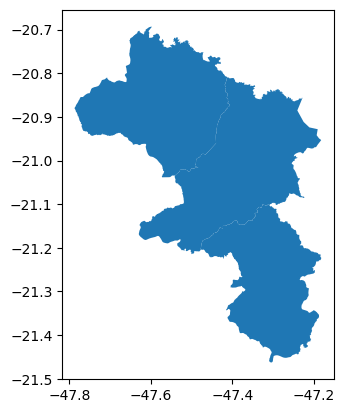

In [7]:
# se você quiser ver como ficou ... Note que os 3 municípios são contíguos, mas não precisaria ser assim.
shape_mun.plot()

Agora, vamos pegar os dados do TerraClimate dentro de cada município. Especificamente neste exemplo, estou focando apenas nos parâmetros: **tmax** Tempertura Máxima, **tmin** Temperatura Mínima, **ppt** Precipitação, **srad** Radiação Solar e **aet** Evapotranspiração. Note que todos esses dados são médias mensais, em um grid regular de 4 km (acesse o [TerraClimate](https://www.climatologylab.org/terraclimate.html) para entender o formato dos dados).

In [8]:
# inicializa todos os arquivos de parâmetros climáticos
# note que aqui tem apenas tmax, tmin, ppt, srad e aet

filesnc = ['http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc',
           'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_tmin_1958_CurrentYear_GLOBE.nc',
           'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc',
           'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_srad_1958_CurrentYear_GLOBE.nc',
           'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_aet_1958_CurrentYear_GLOBE.nc']

In [9]:
import os
import xarray as xr
import salem

# note que esse passo pega TODOS os dados do TerraClimate e baixa para o seu municipio,
# mas só irá fazer isso se o arquivo <municipio>_climate.nc não existir
# note que pode demorar um pouco porque são vários conjuntos de dados.

fnames = [] # inicia um array para os nomes de arquivo

for i,name_mun in enumerate(municipios):
# aqui grava em um netcdf com o nome do municipio. Verifique se o nome está de acordo
    fname = name_mun + '_climate.nc'
    if "/" in fname:
        fname = fname.replace("/","-")
    if " " in fname:
        fname = fname.replace(" ","_")
    print(fname)
    fnames.append(fname)

    if not os.path.exists(fname):
        dclimate = xr.Dataset() # inicializa os dados climáticos
        roi = gpd.GeoDataFrame(shape_mun.iloc[[i]]) # separa a region-of-interest
        print(f'netcdf aberto e pronto.', end="")
        # agora vou baixar os dados climáticos para a mesoregião toda com o salem
        # aqui simplesmente "apontamos para cada arquivo" de dados climáticos
        print(f'Iniciando laço para dados climáticos...', end="")
        for fnc in filesnc:
            dset = xr.open_dataset(fnc)
            varname = list(dset.keys()) # aqui extrai o nome da variável
            print(f'varname:{varname[0]}.', end="")
            myvar = dset.salem.subset(shape=roi) # faz um subset (primeiro! não sei porque mas fazendo roi direto ele dá erro)
            myvar = myvar.salem.roi(shape=roi)  # apaga o que está fora do roi
            myvar_mean = myvar[varname[0]].mean(dim=('lat','lon')).rename(varname[0]+'_mean') # extrai a média regional (por tempo)
            myvar_median = myvar[varname[0]].median(dim=('lat','lon')).rename(varname[0]+'_median') # mediana
            myvar_std = myvar[varname[0]].std(dim=('lat','lon')).rename(varname[0]+'_std') # e desvio padrão
            dclimate = xr.merge([dclimate,myvar_mean,myvar_median,myvar_std],compat='no_conflicts') # merge com o dataset aberto


        dclimate.to_netcdf(fname) # grava um nectdf no disco com o nome da mesorregião
        print(f'Dados climáticos gravados.')
        dclimate.close()
    else:
        print(f'Arquivo de dados climáticos já existe para roi')

Altinópolis_climate.nc
netcdf aberto e pronto.Iniciando laço para dados climáticos...varname:tmax.varname:tmin.varname:ppt.varname:srad.varname:aet.Dados climáticos gravados.
Batatais_climate.nc
netcdf aberto e pronto.Iniciando laço para dados climáticos...varname:tmax.varname:tmin.varname:ppt.varname:srad.varname:aet.Dados climáticos gravados.
Cajuru_climate.nc
netcdf aberto e pronto.Iniciando laço para dados climáticos...varname:tmax.varname:tmin.varname:ppt.varname:srad.varname:aet.Dados climáticos gravados.


Veja que o bloco anterior vai criar uma série de arquivos `nc`, um para cada cidade, e com todas as variáveis climáticas selecionadas.

In [ ]:
# se você quiser ainda gravar esses arquivos no seu computador, basta executar o código abaixo
from google.colab import files

for file in fnames:
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Convertendo em um dataframe

Note que criamos arquivos netcdf com o clima de cada cidade. Você pode transformar cada um destes conjuntos de dados em um dataframe (que basicamente é uma tabela), separando os meses de seu interesse. Note que este conhecimento é algo que você deve ter previamente, por exemplo, *quais os meses de plantio de uma determinada cultura*, ou *quais os meses de colheita de uma determinada cultura*. <br>
Neste exemplo, vamos trabalhar com o arquivo da **primeira cidade** ...

In [10]:
print(f'Os arquivos são:')
for file in fnames:
    print(f'     {file}')

Os arquivos são:
     Altinópolis_climate.nc
     Batatais_climate.nc
     Cajuru_climate.nc


Imagine agora que, com base no calendário do zoneamento agrícola da CONAB para obter essas estimativas, meus períodos de **plantio**,**crescimento** e **colheita** são definidos dessa forma:

- plantio: **Outubro à Dezembro** (mes 10 à 12) (**do ano anterior à estatística!**)
- crescimento: **Janeiro à Março** (mes 1 à 3) (no próprio ano da estatística)
- colheita: **Março à Abril** (mes 3 à 4) (no próprio ano da estatística)

Basta definir esses períodos abaixo.

In [11]:
# selecionando por tempo
dset = xr.open_dataset(fnames[0])

df_plantio = dset.sel(time=dset.time.dt.month.isin([10,11,12])).to_pandas() # <----- plantio
df_cresc = dset.sel(time=dset.time.dt.month.isin([1,2,3])).to_pandas() # <---- crescimento
df_colheita = dset.sel(time=dset.time.dt.month.isin([3,4])).to_pandas() # <----- colheita

In [12]:
# você pode dar uma olhada como ficou
df_plantio.info() # por exemplo

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 1958-10-01 to 2023-12-01
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmax_mean    198 non-null    float32
 1   tmax_median  198 non-null    float32
 2   tmax_std     198 non-null    float32
 3   tmin_mean    198 non-null    float32
 4   tmin_median  198 non-null    float32
 5   tmin_std     198 non-null    float32
 6   ppt_mean     198 non-null    float64
 7   ppt_median   198 non-null    float64
 8   ppt_std      198 non-null    float64
 9   srad_mean    198 non-null    float32
 10  srad_median  198 non-null    float32
 11  srad_std     198 non-null    float32
 12  aet_mean     198 non-null    float32
 13  aet_median   198 non-null    float32
 14  aet_std      198 non-null    float32
dtypes: float32(12), float64(3)
memory usage: 15.5 KB


In [13]:
# Os dados de cada cultura tem um índice definido pelo tempo e estão agrupados pelos meses
# que definimos em cada período (plantio, cresc e colheita)
# aqui, o segredo é fazer um "laço" entre os anos, recuperando os dados corretos dos meses
# que correspondem ao ano "estatístico". Por exemplo: nos dados de 1990, o período de
# plantio corresponde à outubro e novembro de 1989 (ou seja, um ano antes)

ano_min = 1990 # por que eu decidi usar 1990 ? é apenas um detalhe
ano_max = 2023 # <- note que não pode ser maior do que eu tenho gravado

import numpy as np
import pandas as pd

# cria um dataframe vazio
plantio = pd.DataFrame(columns=list(df_plantio)) # pega o nome das colunas de qualquer um dos dataframes criados acima
cresc = pd.DataFrame(columns=list(df_cresc))
colheita = pd.DataFrame(columns=list(df_colheita))

data_plantio = [] # cria matrizes vazias para cada bloco de dados
data_cresc = []
data_colheita = []
ano_estatistico = []

for ano in np.arange(ano_min,ano_max+1): #lembrando que o python sempre precisa desse +1 para fazer o laço corretamente
  #print(f'Construindo os dados para o ano {ano}')
  data_plantio.append(dict(df_plantio.loc[str(ano-1)].agg('mean')))
  data_cresc.append(dict(df_cresc.loc[str(ano)].agg('mean'))) # <--- note que aqui é o ano estatístico
  data_colheita.append(dict(df_colheita.loc[str(ano)].agg('mean')))
  ano_estatistico.append(ano)

plantio = plantio.append(data_plantio,True) # agora junta tudo nos respectivos dataframes
cresc = cresc.append(data_cresc,True)
colheita = colheita.append(data_colheita,True)

plantio.columns = ['plantio_' + str(col) for col in plantio.columns] # adiciona o prefixo nas colunas
cresc.columns = ['cresc_' + str(col) for col in cresc.columns]
colheita.columns = ['colheita_' + str(col) for col in colheita.columns]

In [14]:
# agora concatenamos lateralmente (por coluna) tudo o que fizemos
df_total = pd.DataFrame()
df_total['ano'] = ano_estatistico
df_total = pd.concat([df_total,plantio,cresc,colheita],axis=1)


In [16]:
# veja que agora você tem todos os valores em um dataframe
df_total

,ano,plantio_tmax_mean,plantio_tmax_median,plantio_tmax_std,plantio_tmin_mean,plantio_tmin_median,plantio_tmin_std,plantio_ppt_mean,plantio_ppt_median,plantio_ppt_std,...,colheita_tmin_std,colheita_ppt_mean,colheita_ppt_median,colheita_ppt_std,colheita_srad_mean,colheita_srad_median,colheita_srad_std,colheita_aet_mean,colheita_aet_median,colheita_aet_std
0,1990,26.509359,26.286665,0.860622,16.752905,16.759996,0.358170,150.458156,150.833333,4.201109,...,0.316294,93.954255,93.60,2.750414,198.588287,198.050003,1.863540,98.210648,98.050003,1.322055
1,1991,28.288012,28.056665,0.864989,18.231415,18.239998,0.356098,119.423404,119.700000,2.498791,...,0.319836,163.951064,166.60,9.314017,159.002136,158.399994,1.905950,91.225540,91.150002,1.435378
2,1992,28.044962,27.809996,0.866891,17.412054,17.419998,0.354859,172.858156,172.900000,4.586206,...,0.312381,144.686170,144.55,3.305178,183.824463,183.500000,1.733370,93.356384,93.199997,1.346261
3,1993,27.872339,27.633331,0.869767,16.415741,16.413330,0.359321,234.026950,234.233333,3.831186,...,0.319684,106.267021,106.55,4.382551,192.158508,191.700012,1.746540,99.892563,100.000000,1.007849
4,1994,28.854536,28.609999,0.877341,16.720139,16.723330,0.363522,178.825532,178.133333,3.689193,...,0.322384,176.170213,178.50,7.602587,171.560638,171.150009,1.882605,98.782974,98.449997,1.456836
5,1995,28.450068,28.223330,0.866075,17.949358,17.946665,0.359623,209.341844,209.000000,6.008184,...,0.318441,200.854255,204.10,8.680850,183.279800,183.250000,1.536736,100.327667,100.250000,1.567611
6,1996,27.515814,27.303331,0.852220,17.114820,17.133329,0.352770,227.795745,227.800000,3.757122,...,0.321347,208.627660,211.55,6.659519,182.511703,181.899994,2.027107,93.628723,93.400002,1.305333
7,1997,27.513399,27.273329,0.870307,17.856379,17.849997,0.359334,242.060284,241.633333,5.882732,...,0.326271,71.874468,72.30,2.996805,177.345734,176.899994,2.045221,85.906387,85.750000,0.878819
8,1998,28.719995,28.506666,0.855343,18.225035,18.229996,0.351233,215.834043,215.933333,6.081910,...,0.316769,148.643617,149.70,4.739117,192.814911,192.250000,1.842212,103.927658,103.500000,2.039986
9,1999,27.472620,27.239996,0.863666,16.976664,16.989996,0.357540,191.885106,191.866667,5.770734,...,0.323655,124.367021,126.75,7.331259,193.209595,192.850006,1.797109,92.253189,91.650002,1.536734


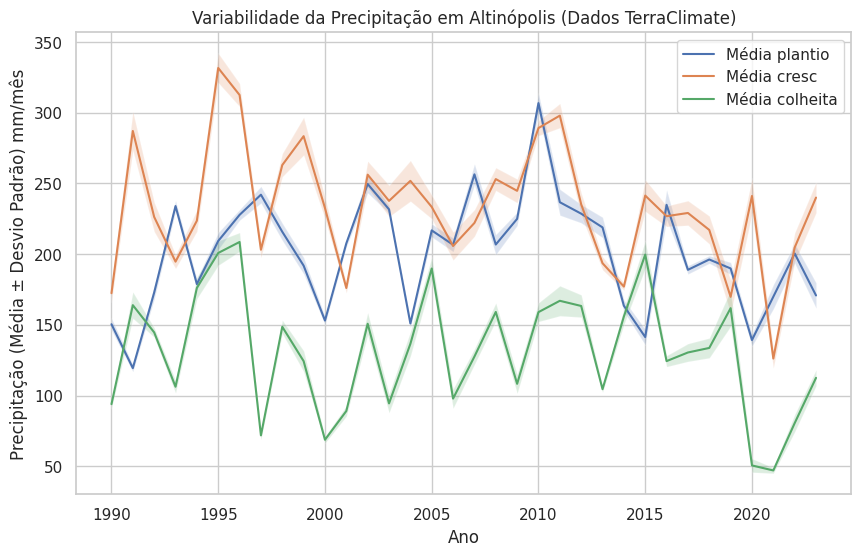

In [18]:
# Vamos fazer um plot, por exemplo, da precipitação média
import seaborn as sns
import matplotlib.pyplot as plt

# Define o estilo dos plots
sns.set(style="whitegrid")

# Cria um gráfico de linha com a média e sombreamento representando o desvio padrão
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_total.ano, y=df_total['plantio_ppt_mean'], label='Média plantio')
plt.fill_between(df_total.ano, df_total['plantio_ppt_mean'] - df_total['plantio_ppt_std'],
                 df_total['plantio_ppt_mean'] + df_total['plantio_ppt_std'], alpha=0.2)

sns.lineplot(x=df_total.ano, y=df_total['cresc_ppt_mean'], label='Média cresc')
plt.fill_between(df_total.ano, df_total['cresc_ppt_mean'] - df_total['cresc_ppt_std'],
                 df_total['cresc_ppt_mean'] + df_total['cresc_ppt_std'], alpha=0.2)

sns.lineplot(x=df_total.ano, y=df_total['colheita_ppt_mean'], label='Média colheita')
plt.fill_between(df_total.ano, df_total['colheita_ppt_mean'] - df_total['colheita_ppt_std'],
                 df_total['colheita_ppt_mean'] + df_total['colheita_ppt_std'], alpha=0.2)

# Adiciona rótulos e título
plt.xlabel('Ano')
plt.ylabel('Precipitação (Média ± Desvio Padrão) mm/mês')
plt.title(f'Variabilidade da Precipitação em {municipios[0]} (Dados TerraClimate)')

# Adiciona a legenda
plt.legend()

# Exibe o gráfico
plt.show()


Embora essa sequencia facilite bastante, ela só significa algo se você **conhece bem** os períodos de plantio, crescimento e colheita do seu município, para a cultura que você está estudando. Então, faça BEM as suas estatísticas.<br>

Adapte o que for necessário. Boa programação.